## Introduction

Think of anytime you decided to create a new account on a specific website. When you choose your username, sometimes the website says that the username is already taken and asks you to find another username. We can easily guess that the website searched for the username that you entered in the username database of the website. This is actually true and that can be done by any search algorithm like linear search or binary search, but using these algorithms would actually take big space and long time especially if the website has a large database. Then how does the website do it that fast?

The answer to that question is Bloom Filters. Bloom filters is a probabilistic data structure that allows you to check whether a specific element exists in a set. Bloom Filters are known to be a space-efficient data structure and at the same time a very fast one in terms of lookups and inserts. To explain why Bloom filters is that good, I will explain how it works:

When we try to insert an element x in a set using bloom filter, bloom filter generates a bit array of n bits where each bit equals zero and then uses k hash functions in order to generate indices for the element x and then sets the value of these indices to 1. So when we want to search for that element in the list, bloom filter uses the same hash functions again to generate the indices for x and then checks the values of these indices, if all of them equal 1 then the element is in the list, if any value is equal to zero then the element is not in the list.

We can notice that because Bloom Filters use hash functions, then collision is possible which means that sometimes the hash functions will generate indices for one element and these indices might also belong to other elements which will lead to a false positive if the element we are searching for is not actually in the list. 
For example, if we have a bloom filter that uses two hash functions and has two elements stored in it. The two elements are occupying the indices 3, 7, 9, 10 which means that the values of these indices in the array are 1 as shown:


Index Value: 
0
0
1
0
0
0
1
0
1
1



 Then if we search for any element x that is not stored in the array and has indices 3, 10 then the bloom filter will find that the values of these indices are 1 and then will return a false positive.


One important property of bloom filters is that it doesn’t allow deletion which means that once an element is inserted, it’s indices values will always remain 1 and that means that bloom filters will never return false negative.
From what we said so far, we can now tell that bloom filters is very space efficient because no matter how large a set of elements we want to store, bloom filter will always save them as bits of arrays where each element in the set is represented by bits only and so the space complexity of the bloom filters is a function of the number of bits in the bits array which then should be O(n) where n = number of bits in the bits array.

Also, the run time of bloom filters when it searches for elements in a set is relatively fast, the bloom filter will go through all the indices of one element to check their values, and because the number of indices generated for one element depend on the number of hash functions used (each one hash function generates one index) then the run time complexity of the search operation in the bloom filter is O(k) where k is the number of hash functions used.

The two advantages mentioned, allow bloom filters to be used in many applications where the space efficiency is very important and a false positive results might be tolerated.

Example Applications:
1- the website scenario that I mentioned above, because the website might have large number of usernames, space efficiency and run time is very important, and having a rare false positive is not a big deal because it will just cost the user few seconds to find a new username.

2 - Another similar application is detecting forbidden passwords. Some websites have a list of forbidden passwords that user can’t use. So whenever a password is entered, the website would use bloom filter to check if it’s not included in the forbidden passwords list

3- spell Checkers. English dictionary has a large number of words. Storing all of them in a list and searching for a specific word would be very costly in terms of space, that’s why bloom filters are used to detect whether a word is spelled correctly or not.



As we said, the biggest disadvantage of bloom filters is the false positive probability, that probability can be controlled and decreased, in order to understand how, let’s calculate that probability:

When we start inserting elements in the bloom filters, the probability for any bit in the array to be set to 1 is 1/n when the hash functions are independent and uniformly distributed. Then the probability for any bit to remain zero is 1- 1/n. And as we keep inserting, the probability of any bit to remain zero is then $(1-1/n)^{ks}$ where k is the number of hash functions and s is the total number of elements to be stored and ks is the number of indices that will be generated by hash functions.

Then the probability of a bit in the array to equal one is $1-(1-1/n)^{ks}$

n= number of bits in the bloom filter
k = number of hash functions
s = number of objects that we want to insert.

Now to simplify the equation, we can consider the fact that e^x is an upper bound for the function 1+x,  then if we take the value (1-1/n) to be 1+x by considering x = -1/n then we can say that 1+x = (1-1/n) has upper bound $e^x$ = $e^{-1/n}$,  that concludes to:

$1-e^{-ks/n}$ as an upper bound for $1-(1-1/n)^{ks}$ 


We can simplify that upper bound by taking n/s = b where b is the number of bits per objects

So the upper bound of getting a positive number is $1-e^{-k/b}$

Which means the probability of getting a positive number is less or equal to $1-e^{-k/b}$


Now the most important part that we are interested in is the probability of getting a false positive. In order to get a false positive from searching for an element x, all the indices values of that element must be one, and because that element has k indices (where k is the number of hash functions) then the probability to get a false positive is $(1-e^{-k/b})^k$

From that equation, we can notice that the error rate can be decreased by increasing the number of bits n in the bits array. Also, as we mentioned that more than one hash function should be used, we can optimize the equation to find the optimal number of hash functions using calculus which will lead to k = ln(2) * (n/s)  where k is the optimal number of hash functions, n is the number of bits in the bits array and s is the total number of elements stored. Then adding these values to the rate equation we get that the false positive rate= .5^(ln(2)*b)  

## Implementation
In order to explain how bloom filter works, please find the application attached with this assignment. I built this application so that students can visualize how bloom filter works and interact more actively with it. Try to enter different words that seem similar and see how the color changes, look up different words and see how the false probability change as you insert more words

Using the same algorithm in the application, I will do this implementation for the sake of the assignment.
In the following implementation, bloom filters checks whether a user generated ID is within the stored IDs or not.
The bloom filter takes as input the bit array size n and the number of hash functions. In this implementation, n value will be assumed and k will be calculated from the equation k = Ln(2) * n/s where s is the number of elements stored in the bloom filter.

In [1]:
import mmh3  #importing the murmurhash3 libarary neccessary for hash functions 
import math #importing the math library that will be used for some caclulations
import random
import string #import this library to generate random strings
import matplotlib.pyplot as plt #for plotting

class bloomfilters:  #identifying the main class
    def __init__(self, n, k): #initializing the main class
        self.bits_count = n  #That's the number of bits
        self.hash_count = k #that's the number of hash functions
        self.bit_array = [0]*self.bits_count  #Making an array with n number of bits 
        self.item_count = 0 #setting a count here for the number of items stored
        
    def insert(self, item): #the insertion ccommand with run time O(k)
        for i in range(self.hash_count): #running inserted item through all the hash functions
            ind = mmh3.hash(item, i) % self.bits_count  #setting the indices for the items
            self.bit_array[ind] = 1  #setting these indices to 1 to store them in the bloom filter
        self.item_count+=1   #counting the number of items stored to use that count in the theoretical calculation of th rate
        return self.bit_array 
    
    def search(self, item): #the searching command with run time O(K)
        for i in range(self.hash_count):  #finding the indicies for the item to be searched
            ind = mmh3.hash(item, i) % self.bits_count  
            if self.bit_array[ind] == 0:  #checking whether that item exists or not in the filter
                return False
        return True
    
    def prob(self):   #This command is to calculate the accurate theoretical probability
        b =  self.bits_count / self.item_count  #number of bits per item
        probability =  (.5)**(math.log(2)*b) # Calculating the theoretical false positive probability 
        return probability
    


added_words= []  #generating a list of random words to store in the filter
Not_added_words = [] #generating a list of words to test with
for _ in range(100):  #Using that loop to generate 100 words
    x = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(10)) #this command is from the string library to generate random words
    y = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(10))
    added_words.append(x) 
    Not_added_words.append(y)


test_words = added_words+ Not_added_words  #adding the above lists to make a new list to test with
random.shuffle(test_words)
def test():  #this function is used to test the bloom filter
    test_list = []  #I will use this list to know when the bloom filter returns a false positive.
    s = len(added_words) #number of items stored
    b = 4 # Here I'm adding a value for the bits per array to use it to get an appropriate number of bits
    n = b*s #number of bits
    k = int(math.log(2) * b)  #optimal number for hash functions
    
    bf =   bloomfilters(n, k) #starting the bloom filter 

    for i in added_words: 
        bf.insert(i)  #adding the words to the bloom filter 
        test_list.append(i) #adding the same words to the test list to catch the false positive
        
    
    error = 0  # this will be used to count the number of false positive
    total = 0 #this will be used to count the total number of positives returned by the bloom
    
    for i in test_words:
        if bf.search(i): 
            total+=1 #if the bloom returns positive about that item, will increase the numer of total by 1
            if i in test_list: 
                print ('"' +str(i)+'"', "is in the bloom filter") #then if that number is in the test list then the bloom didn't lie
            else:
                print('"' +str(i)+'"', "Returned a false positive") #but if it's not then the bloom is returning a false positive
                error+=1
                
                
        else:
            print('"' +str(i)+'"', "is not in the bloom filter")
    print("\n \n")
    print("Empirical False Positive Rate:",int((error/total)*100))      
    print("Theoretical False Positive Rate",bf.prob()*100)
test()

('"4O2U7JHHMZ"', 'is in the bloom filter')
('"ZIN9TVQ0SI"', 'is in the bloom filter')
('"SR151PJ7JL"', 'is in the bloom filter')
('"6RXJ0NWMOD"', 'is in the bloom filter')
('"NT5H4Q9JRE"', 'is not in the bloom filter')
('"RLENML2ENL"', 'Returned a false positive')
('"QBWVDASMUB"', 'is not in the bloom filter')
('"4KE85X2VNP"', 'is not in the bloom filter')
('"BJAC3Q5RMF"', 'is in the bloom filter')
('"LAU5A0TU2Y"', 'is in the bloom filter')
('"MQT8DJ06A9"', 'is not in the bloom filter')
('"MVVC3EDHHT"', 'is in the bloom filter')
('"WRF9HNWD0N"', 'is not in the bloom filter')
('"CRQID4F4FP"', 'is in the bloom filter')
('"7DJ5WK27B2"', 'is in the bloom filter')
('"PQMMS9GWOV"', 'is in the bloom filter')
('"MV31GUDU33"', 'is in the bloom filter')
('"1VIQ2SCPUB"', 'is not in the bloom filter')
('"KZZFL1LUEX"', 'is in the bloom filter')
('"EXMM4RCUS3"', 'is in the bloom filter')
('"G65MXPFELJ"', 'is not in the bloom filter')
('"4018CFDP1G"', 'is in the bloom filter')
('"F63X4X3Y39"', 'is no

As I mentioned before while I was calculating the probability of false positive, we must have independent and uniformly distributed hash functions, and they should be as fast as possible. That's why I chose the murmurhash3 functions which are a set of fast hash functions that are independent and uniformly distributed, they use 3 basic operations as a whole: Multiply, Rotate and XOR so using them maximize the quality of the distribution, and minimize the number of collisions. Saying that, I can tell that the error rate in my implementation is given by the equation:  $.5^{ln(2)*b}$ as proved in the introduction above

## Memory size as a function of the false positive rate
As I mentioned before, the memory size of bloom filters is a function of the number of bits in the filter which means that the space complexity is O(n) where n is the number of bits in the bits array. From the error rate equation $r = .5^{ln(2)* n/s}$ we find that n = $ \frac{-s*ln(r)}{ln(2)*ln(.5)} $

The s is the number of words that I need to store which is constant in my implementation because I run it for the same number of words everytime so the number of bits is independent on the number of items stored so the memory size complexity = -C* ln(r) which is O(ln(1/r)). 

The following graph ilusstrates this relationship:

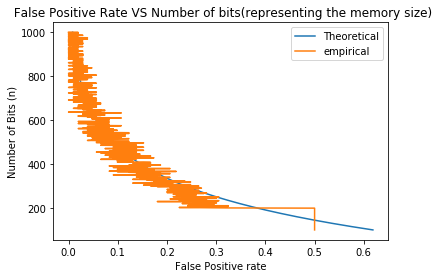

In [2]:
def r_n(): #defining a function to plot the relationship between the false positive rate and the number of bits which represents the memory
    test_list = [] #Again as above, bringing a test list here to catch the bloom filter when it lies 
    s = len(added_words)
    array_size = [] #Number of bits in the array
    error_rate = [] #this list will contain the different values for the false positive rate
    theo_error_rate = [] #this list will contain different values for the theoretical false positive rate
    for n in range(100, 1000): #adding different numbers for the bits
        array_size.append(n) 
        k = int(math.log(2) * (n/s)) #Using the optimal number of hash functions
        bf = bloomfilters(n, k) #starting a new bloom filter with the above values
        for i in added_words: 
                bf.insert(i)  #inserting the values into the bloom filter
                test_list.append(i) #inserting the same values in the test list (to catch the liar bloom filter :D )
        total = 0  #again as previously, using these to calculate the empirical false positive
        error = 0
        for i in test_words:  
            if bf.search(i):  #if the bloom returns a positive about the item,then I increment total by 2
                total+=1
                if i not in test_list: #if the item is not in the list then it's a false positive
                    error+=1
                    
        errorRate = error/total  #calculating the false positive rate 
        
        error_rate.append(errorRate)  #Appending the emprirical false positive rate 
        theo_error_rate.append(bf.prob()) #Appending the theoreitical false positive rate 
            
    #Here, I'm making the best out of the #dataviz HC :D
    
    plt.plot(theo_error_rate,array_size, label = "Theoretical") 
    plt.xlabel("False Positive rate")
    plt.ylabel("Number of Bits (n)")
    plt.plot(error_rate,array_size ,label = "empirical")
    plt.legend()
    plt.title(" False Positive Rate VS Number of bits(representing the memory size)")
    plt.show()


r_n()


#Please note that the following plot has some noise that can be eliminated by running several times for each n and then plotting the averages but If I do that, it 
#will take a long running time so I skipped that step.

## Memory size as a function of the number of items stored

The number of items that are stored is constant because I run my implementation with the same number of words every time. Also, the number of bits is independent on the number of item stored because for any number of items I can assign the bloom filter any number of bits. So the memory size as a function in the items stored is O(constant). 

As illustrated by the following:

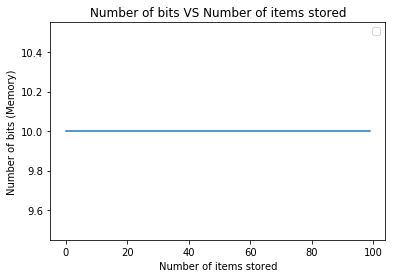

In [3]:
def s_n(): #this is a function to show the relationship between the nuber of items stored and the number of bits which reoresents the memory size

    items_number = [] #list to store the different number of items to plot
    bits_number = []  #list to store the differnt number of bits
    added_words= []   
    Not_added_words = []
    for s in range(100):  #different values for the items to be stored
        items_number.append(s)  
        for _ in range(s):
            x = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(10))  #generating random strings
            y = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(10))
            added_words.append(x)
            Not_added_words.append(y)
        test_words = added_words+ Not_added_words  #generating test words
        random.shuffle(test_words)
        bf =bloomfilters(10, 10) #starting the bloom filter with values for the hash functions and the number of bits independent of the number of items stored
        for i in added_words:
            bf.insert(i)
        bits_number.append(bf.bits_count)   #adding the number of bits
            
            
        
    #Plotting: 
    
    plt.xlabel("Number of items stored")
    plt.ylabel("Number of bits (Memory)")
    plt.plot(items_number, bits_number )
    plt.legend()
    plt.title("Number of bits VS Number of items stored")
    plt.show()
    

s_n()

#The following graph shows that as the number of items stored increases, the number of bits (memory) doesn't change:  n = O(constant)

## Access time as a function of the false positive rate
The run time for search and insert operations of my implementaion is O(k) where k is the number of hash functions. That's because the search and insert go through all the hash functions with a for loop to generate indices which takes K time and then updates or checks the values of these indices in a constant time. So the access time in a function of K is O(k).  k = $\frac{n}{s} * ln(2) $ then replacing $\frac{n}{s}$ with its optimal value which is $ \frac{ln(r)}{ln(2)*ln(.5)} $ then we get that k = $\frac{ln(r)}{ln(.5)}$  then the access time as a function of the false positive probability is O(ln(1/r)). 

This relationship is illustrated by the following graph:

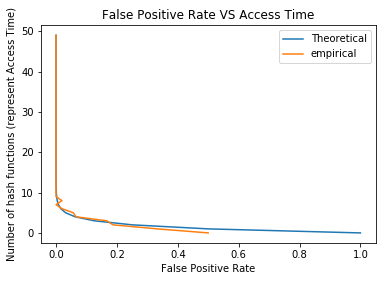

In [4]:
def r_k(): #this function shows the relationship between the false positive rate and the number of hash functions which represents the run time
    test_list = []
    s = len(added_words) 
    array_size = []  #List to store different values for hash functions
    error_rate = [] #List to store different values for the empirical false positive rate
    theo_error_rate = [] #list to store different values for the empirical false positive rate

    for k in range(0, 50):  #using different values for the hash functions
        array_size.append(k)
       
        n= int(s*k/math.log(2)) #optimal value for the number of bits
        bf = bloomfilters(n, k) #starting the bloom filter with these values
        
        for i in added_words:   #adding items in the bloom filter and the test list
                bf.insert(i)  
                test_list.append(i)
        total = 0  #setting these values to calculate the false positive probability
        error = 0
        for i in test_words: 
            if bf.search(i):  #searching for the item and incrementing total by 1 if bf returns True
                total+=1
                if i not in test_list: #Incrementing error if the item is not in the test list
                    error+=1
                    
        errorRate = error/total
        
        error_rate.append(errorRate)  #Adding the value of the empirical false probability to the list
        theo_error_rate.append(bf.prob())  #Adding the value of the theoretical false probability to the list
            
    #plotting:   

    plt.plot(theo_error_rate,array_size, label = "Theoretical")
    plt.xlabel("False Positive Rate")
    plt.ylabel("Number of hash functions (represent Access Time)")
    plt.plot(error_rate,array_size, label = "empirical")
    plt.legend()
    plt.title("False Positive Rate VS Access Time")
    plt.show()
r_k()


#The following graph shows the relationship between the false positive probability and the number of hash functions which undergoes: k= O(ln(1/r))

## Access time as a function of the number of items stored
Again, the number of items in my implementation is constant and so it doesn't affect the run time because the run time depends on the number of hash functions because in any case we just need to run the inputs through all the hash functions. Then changing the number of items stored will not affect the run time and so the access time in terms of items stored is O(Constant)

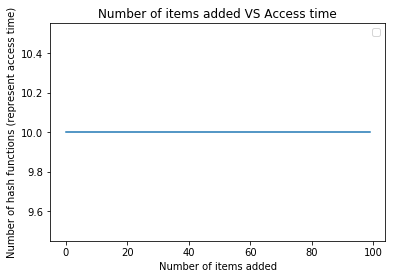

In [5]:
def s_n():  #This function is used to show the relationship between the number of items stored and the number of hash functions

    items_number = []  #list to store the number of items stored
    hash_number = []  #list to store the number of hash functions
    added_words= []
    Not_added_words = []
    for s in range(100):  #generating different values for the number of items to be stored:
        items_number.append(s)
        for _ in range(s):
            x = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(10))
            y = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(10))
            added_words.append(x)
            Not_added_words.append(y)
        test_words = added_words+ Not_added_words #generating a list of words to test with
        random.shuffle(test_words)
        bf =bloomfilters(10, 10)  #starting the bloom filter with values for n and k independent of the number of items stored
        for i in added_words:
            bf.insert(i)
        hash_number.append(bf.hash_count)   #adding the number of bits
            
            
        
    #Plotting:
    
    plt.xlabel("Number of items added")
    plt.ylabel("Number of hash functions (represent access time)")
    plt.plot(items_number, hash_number )
    plt.legend()
    plt.title("Number of items added VS Access time")
    plt.show()
    

s_n()


#The following grapg shows that as the number of items stored increases, the number of hash functions stays the same: k = O(constant)

## Implementation’s false positive rate VS theoretically expected rate.

In the introduction section, I proved that the false positive rate of the optimal bloom filter should equal to $$.5^{ln(2)*b}$$. The bloom filter in my implementation takes as input the number of array bits and the number of hash function. So in order to prove that my implementation matches the theoretically expected rate mentioned, I will generate two plots, one that shows the effect on the false positive rate when the number of array bits increase and the other shows the effect on the false positive rate when the number of hash functions increase and I will compare the empirical and the theoretical implementation in each graph as the follwoing:

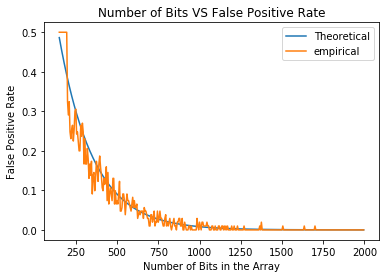

In [6]:
def prob_test():  #this function shows the effect on the false positive rate when the number of bits increase
    test_list = []
    s = len(added_words)  #number of items stored
    array_size = []  #List to store the number of bits 
    error_rate = [] #list to store the empirical error rates
    theo_error_rate = []  #list to store the theoretical error rates
    for n in range(150, 2000, 5):  #Because I have 100 items stored, I will start the number of bits as 150 and then will keep increasing it by 5 to have a variety of bits number
        array_size.append(n)
        k = int(math.log(2) * (n/s)) #using the optimal number of hash functions
        bf = bloomfilters(n, k) #starting the bloom filter with these values
        
        for i in added_words: 
                bf.insert(i)  #inserting the items in both the bloof filter and the list
                test_list.append(i)
        total = 0
        error = 0
        for i in test_words:   #searching for the itema nd incrementing the total by 1 when bf returns True
            if bf.search(i):
                total+=1
                if i not in test_list:  #incrementing the error by 1 when the item is not in the list
                    error+=1
                    
        errorRate = error/total #calculating the false positive rate 
        
        error_rate.append(errorRate)  #Appending the empirical value for the error rate
        theo_error_rate.append(bf.prob())  #appending the theoretical value for the error rate
            
    #plotting:

    plt.plot(array_size,theo_error_rate, label = "Theoretical")
    plt.xlabel("Number of Bits in the Array")
    plt.ylabel("False Positive Rate")
    plt.plot(array_size,error_rate, label = "empirical")
    plt.legend()
    plt.title("Number of Bits VS False Positive Rate")
    plt.show()
prob_test()
                    

    


The graph above shows that when the number of bits increases while the number of hash functions remains optimal according to the equation k = $\frac{n}{s}*ln(2)$, 
both the empirical and theoretical false positive rate match according to the equation $.5^{ln(2)*b}$ where b is $\frac{n}{s}$ (the number of bits over the number of items stored)

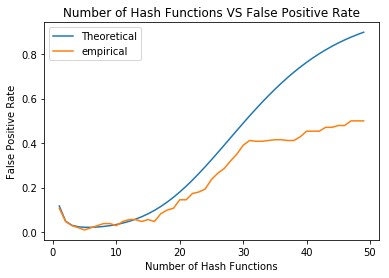

In [7]:
def k_f(): # This function shows the effect of increasing the number of hash functions on the false positive probability
    test_list = []  
    s = len(added_words)  #number of items stored
    array_size = []  #number of hash functions
    error_rate = []  # emprical error rates
    theo_error_rate = []  #theoretical error rates
    b = 8  # Here, I'm using an optimal value for the number of bits per array to calculate an appropriate number of bits
    for k in range(1, 50):  #generating different values for the hash functions
        array_size.append(k)
        n = b *len(added_words)  #number of bits
        bf = bloomfilters(n, k)  #starting the bloom filter with these values
        for i in added_words:  
                bf.insert(i)  #inserting the items in both the bloom filter and the test list
                test_list.append(i)
        total = 0
        error = 0
        for i in test_words:  #searching for the word and incrementing total if the bf returns True
            if bf.search(i):
                total+=1
                if i not in test_list: #incrementing error if the word is not in the list
                    error+=1
                    
        errorRate = error/total  
        
        error_rate.append(errorRate)  #adding the false positive rate
        probability =  (1-math.exp((-k/b)))**k  #calculating the theoretical probability using the number of hash functions and bits per item
        theo_error_rate.append(probability)  
      
        
    #Plotting:
    plt.plot(array_size,theo_error_rate, label = "Theoretical")
    plt.xlabel("Number of Hash Functions")
    plt.ylabel("False Positive Rate")
    plt.plot(array_size,error_rate, label = "empirical")
    plt.legend()
    plt.title("Number of Hash Functions VS False Positive Rate")
    plt.show()
k_f()
                    


The graph above shows that when the number of hash functions increases, while the number of bits remains constant, both the empirical and theoretical false positive rate match and decrease then suddenly increase. Please note that the global minimum of that plot is actually the optimal number of hash functions that must be used to reduce the false positive rate which is given by the equation: k = $\frac{n}{s}*ln(2)$ before this value the false positive rate is decreasing and after it it's increasing. 

This is more clear in the interactive application attached below.

##

As the purpose of this assignment is to explain bloom filter to one of my peers, I decided to build an interactive application to let my peers explore how the different parameters of bloom filters interact. 

The application has two interactive plots, the first one is a plot of the number of bits per item VS the false positive rate, it allows the user to add the values for K and see how that changes the graph. The goal of that model is to make students understand the concept of the optimal value for the number of hash functions as before that value the graph will show a decrease in the false positive rate and after it the graph will show an increase.


The second one is a plot of the number of hash functions VS the false positive rate. Similar to the first one, students can enter different values for the number of bits and the number of items stored and see how that affect the graph. This plot can help students understand and visualize many things about bloom filters like seeing how the value of the optimal number of hash functions change (the minima of the function) and also exploring the optimal number of bits per array (the one that can decrease the false positve rate the most)

## Appendix

##professionalism: I followed the established guidlines to present my work professionally.

##audience: I made sure to make my assignment clear to my audience who are students who might have no prior knowledge about bloom filters. So I explained it clearly from scratch and mathematically proved every equation I used. To make things even more clear, I designed an interactive application for them to understand and visualize bloom filters more deeply.

##composition: I used a clear and precise style to make my assignment understandable and easy to comprehend 

##modeling: I modeled two interactive plots to explain the parameters of bloom filters

##correlation: In the last two plots, I used the correlation between the theoretical and empirical run time to prove that they match

##Algorithms: I used algorithmic thinking to implement the bloom filters and empirically find the false positive rate and prove that it matches the theoretical one.

##dataviz: I clearly created data visualizations with legends, titles and labels to make it clear and easy to understand and read.

